In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter, ImageChops

In [93]:
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

In [4]:
def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
#pre_pare
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])

def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).to(device)  + torch.Tensor([0.485, 0.456, 0.406]).to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.to(device)
modulelist = list(vgg.features.modules())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [129]:
a=torch.tensor([1,2,3],dtype=torch.float,requires_grad=True)

In [130]:
b=torch.tensor([4,5,6],dtype=torch.float,requires_grad=True)

In [131]:
c=a*a+b

In [132]:
c.sum().backward()

In [133]:
a.grad

tensor([2., 4., 6.])

In [128]:
c

tensor([ 5.,  9., 15.], grad_fn=<AddBackward0>)

In [134]:
# 这是一个关于 PyTorch 是动态图的例子：
a = torch.tensor([3.0, 1.0], requires_grad=True)
b = a * a
loss = b.mean()

loss.backward() # 正常
loss.backward() # RuntimeError

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [135]:
# 第二次：从头再来一遍
a = torch.tensor([3.0, 1.0], requires_grad=True)
b = a * a
loss = b.mean()
loss.backward() # 正常

In [136]:
! unzip computing_graph_demo.zip

Archive:  computing_graph_demo.zip
   creating: computing_graph_demo/
  inflating: computing_graph_demo/.gitignore  
   creating: computing_graph_demo/data/
  inflating: computing_graph_demo/data/bird.csv  
  inflating: computing_graph_demo/deepfm.py  
  inflating: computing_graph_demo/ffm.py  
  inflating: computing_graph_demo/fm.py  
  inflating: computing_graph_demo/graph.py  
  inflating: computing_graph_demo/layer.py  
   creating: computing_graph_demo/lost & found/
  inflating: computing_graph_demo/lost & found/gradient_show.py  
  inflating: computing_graph_demo/lost & found/test_cnn.py  
  inflating: computing_graph_demo/lost & found/test_flatten.py  
  inflating: computing_graph_demo/lost & found/test_linear_regression.py  
  inflating: computing_graph_demo/lost & found/test_lr.py  
  inflating: computing_graph_demo/lost & found/test_lr_2.py  
  inflating: computing_graph_demo/lost & found/test_misc.py  
  inflating: computing_graph_demo/lost & found/test_nn.py  
  inflating: 

In [116]:
torch.tensor

<function _VariableFunctions.tensor>

In [95]:
def dd_helper(image,modulelist, layerID, iterations, lr=0.1):        
    print('iterations',iterations)
    input = torch.tensor(preprocess(image).unsqueeze(0).to(device), requires_grad=True)
    print('input shape',input.shape)
    vgg.zero_grad()
    for i in range(iterations):
#         print('Iteration: ', i)
        out = input
        for j in range(layerID):#这里面是运行多少次
            out = modulelist[j+1](out)
        loss = out.norm()
        loss.backward()
        input.data = input.data + lr * input.grad.data
        #print(input.grad.data.abs().mean())
        input.grad.data.zero_()
        #print(input.grad.data.abs().mean())
    input = input.data.squeeze()
    input.transpose_(0,1)
    input.transpose_(1,2)
    input = np.clip(deprocess(input).cpu(), 0, 1)#把算完之后的图片变化到限制到0,1之间。
    
    im = Image.fromarray(np.uint8(input*255))#从数组生成图像。
    return im

In [112]:
def deep_dream_vgg(image,modulelist,layer, iterations, lr, octave_scale, num_octaves):
    print('num_octaves',num_octaves)
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))#这里面是给图像加上一些高斯噪声。
        if(image1.size[0]/octave_scale < 1 or image1.size[1]/octave_scale<1):#size的尺寸小于1的时候就不去管它了
            size = image1.size
        else:
            size = (int(image1.size[0]/octave_scale), int(image1.size[1]/octave_scale))#否则长宽就会除以2
            
        image1 = image1.resize(size,Image.ANTIALIAS)
        image1 = deep_dream_vgg(image1,modulelist,layer, iterations, lr, octave_scale, num_octaves-1)
        
        size = (image.size[0], image.size[1])
        print('image size',size)
        image1 = image1.resize(size,Image.ANTIALIAS)
        print('image shape',image.size,'image1 shape',image1.size)
        image = ImageChops.blend(image, image1, 0.6)
        
#     print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image,modulelist,layer, iterations, lr)
    img_result = img_result.resize(image.size)
    print('end')
    plt.imshow(img_result)
    return img_result

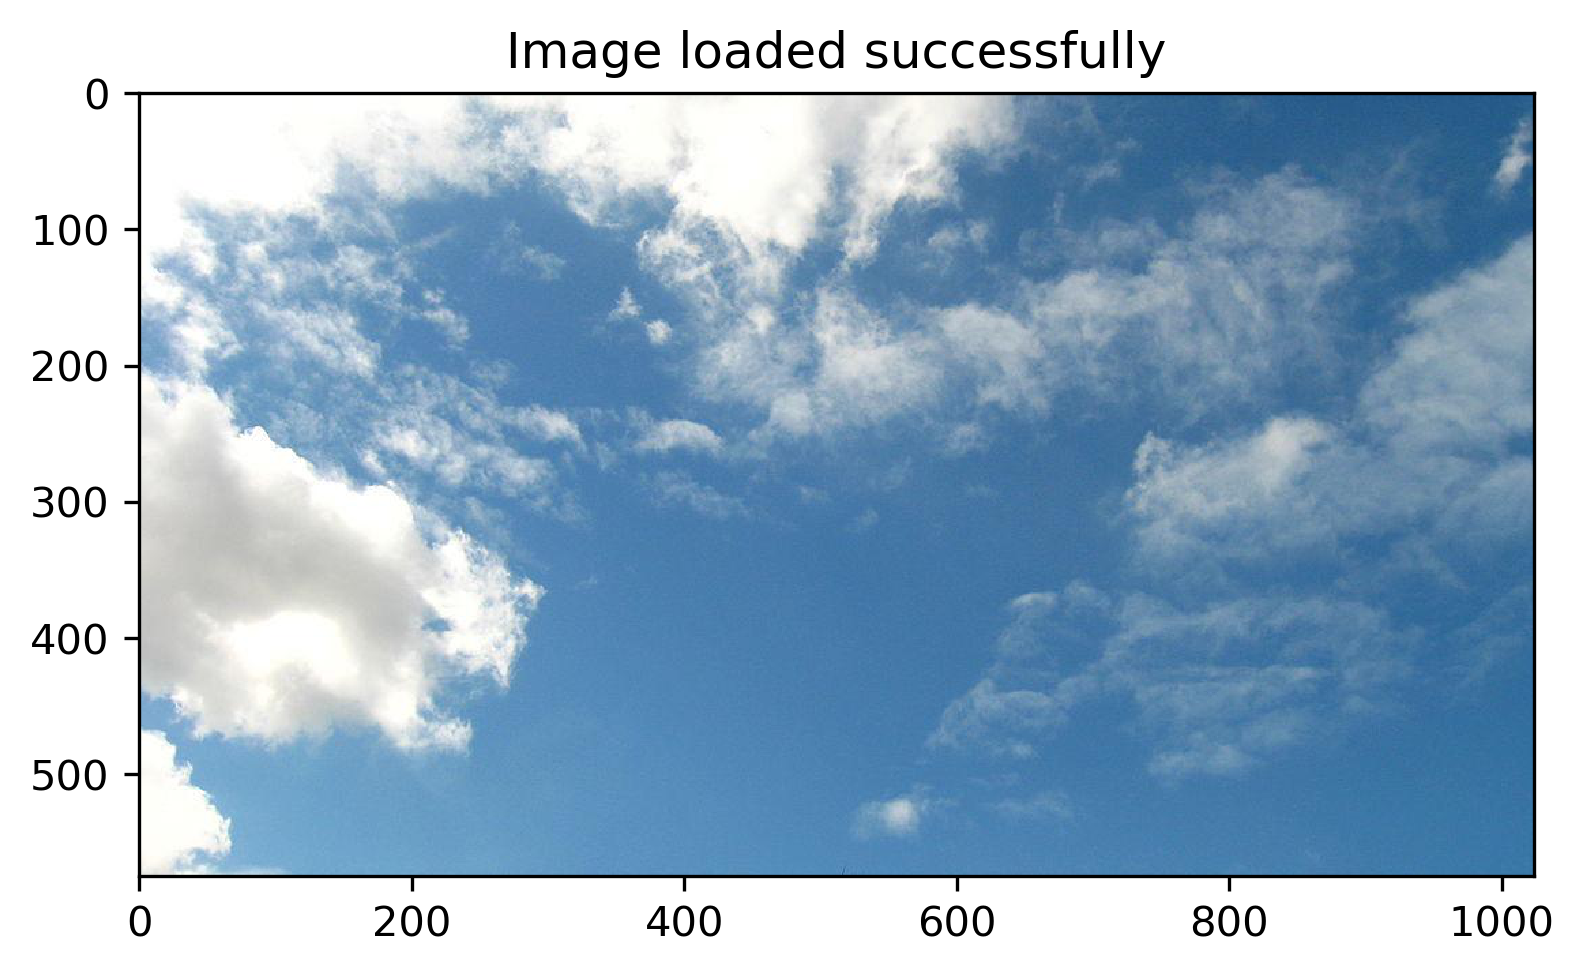

In [110]:
sky = load_image('cloud_picture.jpg')

num_octaves 20
num_octaves 19
num_octaves 18
num_octaves 17
num_octaves 16
num_octaves 15
num_octaves 14
num_octaves 13
num_octaves 12
num_octaves 11
num_octaves 10
num_octaves 9
num_octaves 8
num_octaves 7
num_octaves 6
num_octaves 5
num_octaves 4
num_octaves 3
num_octaves 2
num_octaves 1
num_octaves 0
iterations 5
input shape torch.Size([1, 3, 224, 224])
end
image size (2, 1)
image shape (2, 1) image1 shape (2, 1)
iterations 5
input shape torch.Size([1, 3, 224, 224])
end
image size (2, 1)
image shape (2, 1) image1 shape (2, 1)
iterations 5
input shape torch.Size([1, 3, 224, 224])


/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


end
image size (2, 1)
image shape (2, 1) image1 shape (2, 1)
iterations 5
input shape torch.Size([1, 3, 224, 224])
end
image size (2, 1)
image shape (2, 1) image1 shape (2, 1)
iterations 5
input shape torch.Size([1, 3, 224, 224])
end
image size (2, 1)
image shape (2, 1) image1 shape (2, 1)
iterations 5
input shape torch.Size([1, 3, 224, 224])
end
image size (2, 1)
image shape (2, 1) image1 shape (2, 1)
iterations 5
input shape torch.Size([1, 3, 224, 224])
end
image size (2, 1)
image shape (2, 1) image1 shape (2, 1)
iterations 5
input shape torch.Size([1, 3, 224, 224])
end
image size (2, 1)
image shape (2, 1) image1 shape (2, 1)
iterations 5
input shape torch.Size([1, 3, 224, 224])
end
image size (2, 1)
image shape (2, 1) image1 shape (2, 1)
iterations 5
input shape torch.Size([1, 3, 224, 224])
end
image size (2, 1)
image shape (2, 1) image1 shape (2, 1)
iterations 5
input shape torch.Size([1, 3, 224, 224])
end
image size (2, 1)
image shape (2, 1) image1 shape (2, 1)
iterations 5
input 

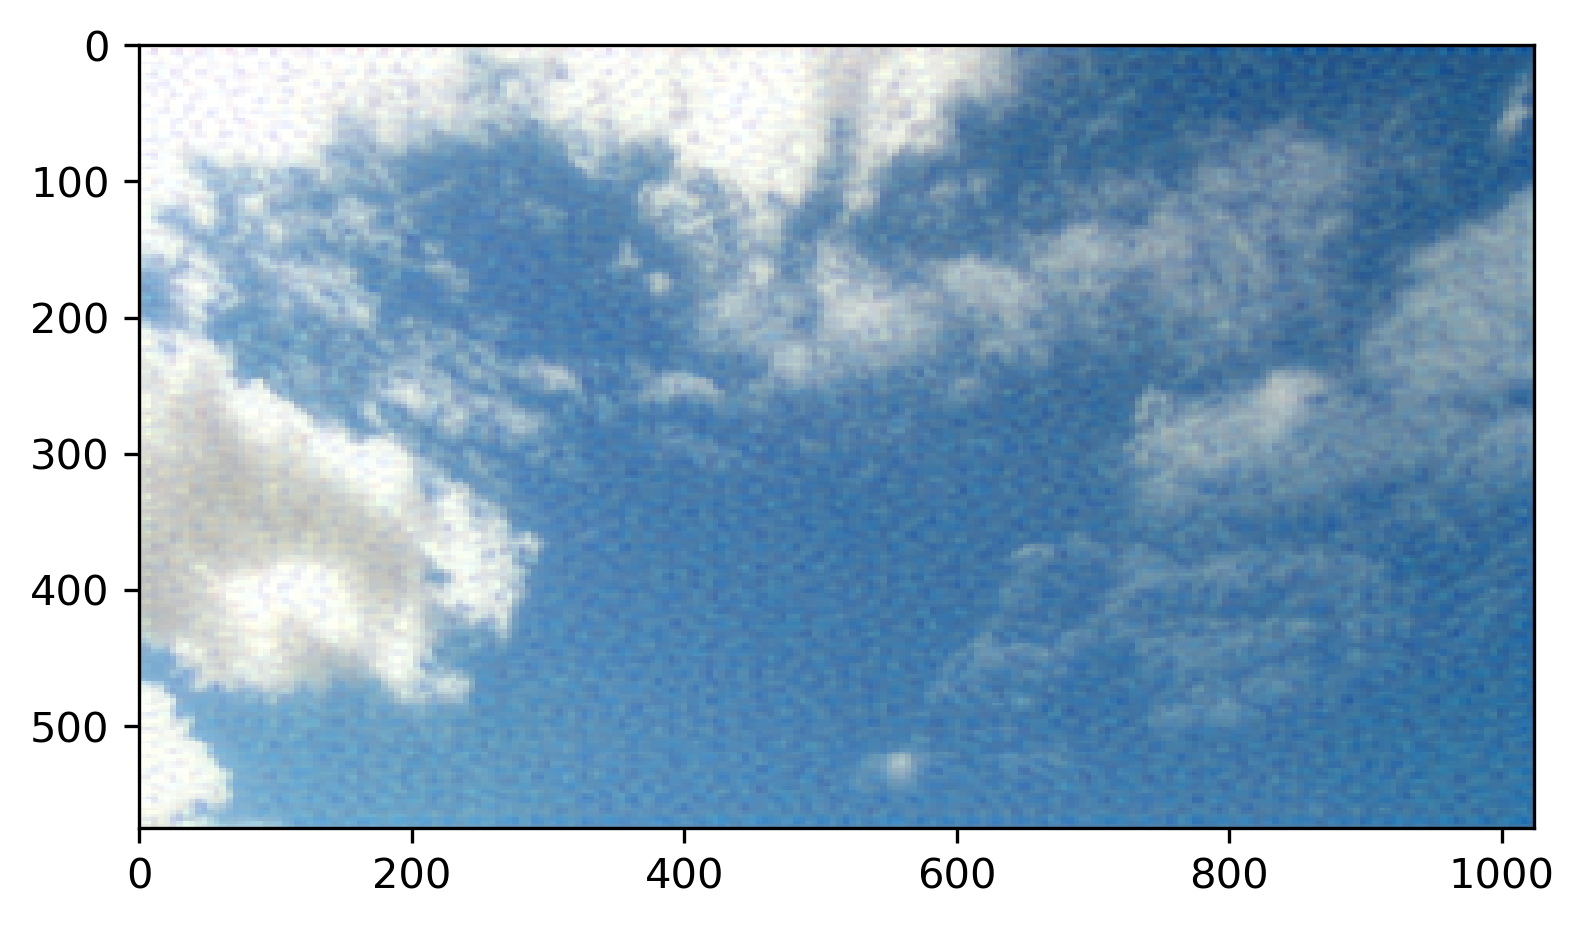

In [113]:
sky_5 = deep_dream_vgg(sky,modulelist, 5, 5, 0.3, 2, 20)

num_octaves 20
num_octaves 19
num_octaves 18
num_octaves 17
num_octaves 16
num_octaves 15
num_octaves 14
num_octaves 13
num_octaves 12
num_octaves 11
num_octaves 10
num_octaves 9
num_octaves 8
num_octaves 7
num_octaves 6
num_octaves 5
num_octaves 4
num_octaves 3
num_octaves 2
num_octaves 1
num_octaves 0
iterations 4
input shape torch.Size([1, 3, 224, 224])
image size (2, 1)
iterations 4
input shape torch.Size([1, 3, 224, 224])
image size (2, 1)
iterations 4
input shape torch.Size([1, 3, 224, 224])
image size (2, 1)
iterations 4
input shape torch.Size([1, 3, 224, 224])
image size (2, 1)
iterations 4
input shape torch.Size([1, 3, 224, 224])
image size (2, 1)
iterations 4
input shape torch.Size([1, 3, 224, 224])


/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


image size (2, 1)
iterations 4
input shape torch.Size([1, 3, 224, 224])
image size (2, 1)
iterations 4
input shape torch.Size([1, 3, 224, 224])
image size (2, 1)
iterations 4
input shape torch.Size([1, 3, 224, 224])
image size (2, 1)
iterations 4
input shape torch.Size([1, 3, 224, 224])
image size (2, 1)
iterations 4
input shape torch.Size([1, 3, 224, 224])
image size (2, 1)
iterations 4
input shape torch.Size([1, 3, 224, 224])
image size (4, 2)
iterations 4
input shape torch.Size([1, 3, 224, 224])
image size (8, 4)
iterations 4
input shape torch.Size([1, 3, 224, 224])
image size (16, 8)
iterations 4
input shape torch.Size([1, 3, 224, 224])
image size (32, 17)
iterations 4
input shape torch.Size([1, 3, 224, 224])
image size (64, 35)
iterations 4
input shape torch.Size([1, 3, 224, 224])
image size (128, 71)
iterations 4
input shape torch.Size([1, 3, 224, 224])
image size (256, 143)
iterations 4
input shape torch.Size([1, 3, 224, 224])
image size (512, 287)
iterations 4
input shape torch

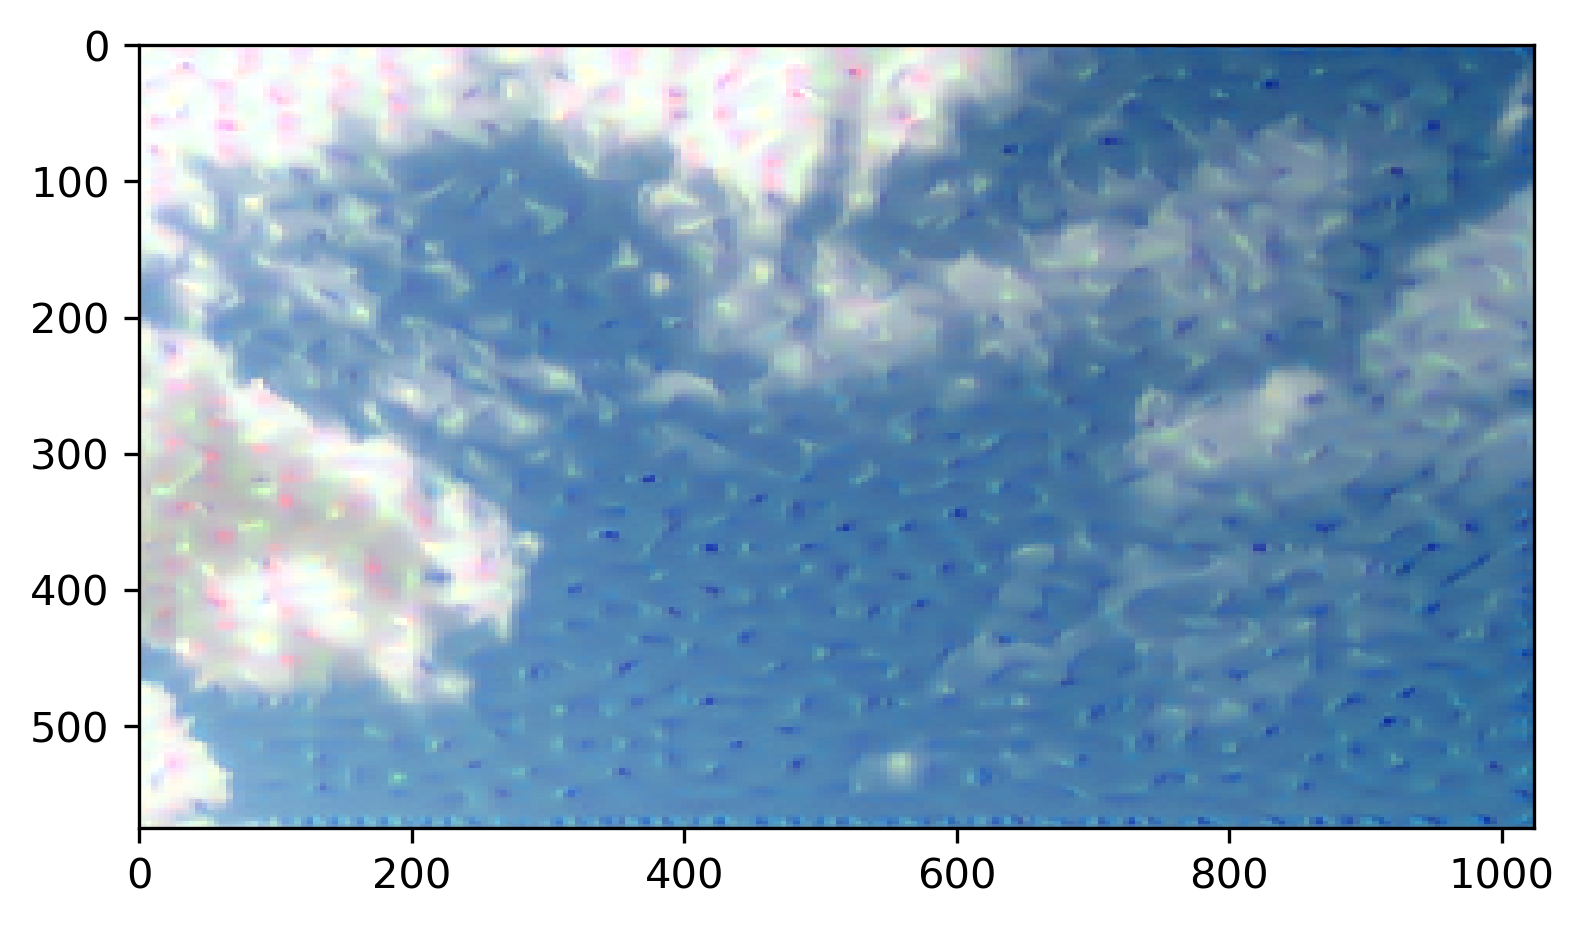

In [105]:
sky_7 = deep_dream_vgg(sky,modulelist, 7, 4, 0.3, 2, 20)

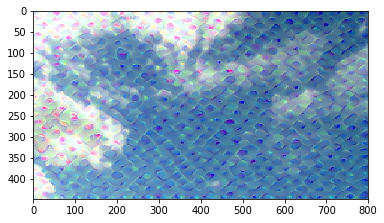

In [9]:
sky_10 = deep_dream_vgg(sky, 10, 3, 0.3, 2, 20)

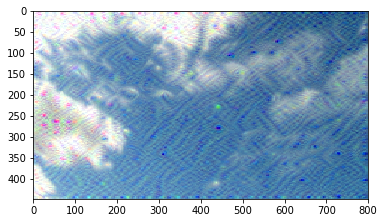

In [10]:
sky_12 = deep_dream_vgg(sky, 12, 2, 0.3, 2, 20)

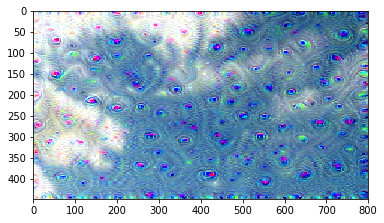

In [11]:
sky_14 = deep_dream_vgg(sky, 14, 3, 0.3, 2, 20)

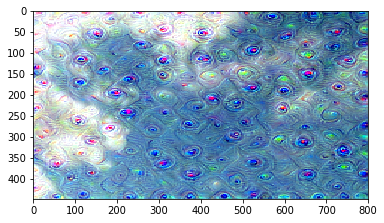

In [12]:
sky_17 = deep_dream_vgg(sky, 17, 3, 0.3, 2, 20)

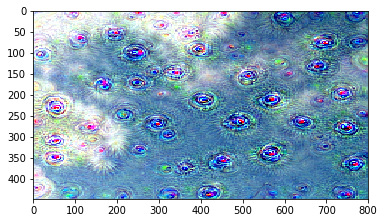

In [13]:
sky_19 = deep_dream_vgg(sky, 19, 3, 0.3, 2, 20)

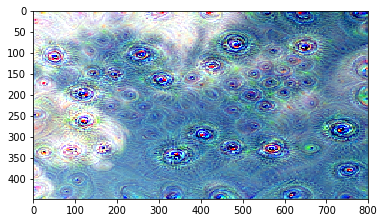

In [14]:
sky_21 = deep_dream_vgg(sky, 21, 3, 0.3, 2, 20)

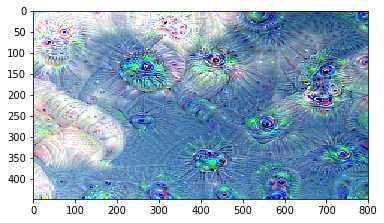

In [15]:
sky_24 = deep_dream_vgg(sky, 24, 5, 0.2, 2, 20)

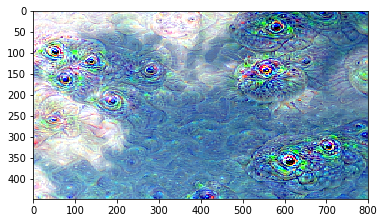

In [16]:
sky_26 = deep_dream_vgg(sky, 26, 5, 0.2, 2, 20)

iterations 20
tensor(0.0204, device='cuda:0')
tensor(0.0656, device='cuda:0')
tensor(0.1095, device='cuda:0')
tensor(0.1229, device='cuda:0')
tensor(0.1400, device='cuda:0')
tensor(0.1429, device='cuda:0')


/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


tensor(0.1570, device='cuda:0')
tensor(0.1720, device='cuda:0')
tensor(0.1733, device='cuda:0')
tensor(0.1761, device='cuda:0')
tensor(0.1768, device='cuda:0')
tensor(0.1721, device='cuda:0')
tensor(0.1750, device='cuda:0')
tensor(0.1688, device='cuda:0')
tensor(0.1714, device='cuda:0')
tensor(0.1659, device='cuda:0')
tensor(0.1617, device='cuda:0')
tensor(0.1582, device='cuda:0')
tensor(0.1572, device='cuda:0')
tensor(0.1555, device='cuda:0')
iterations 20
tensor(0.0227, device='cuda:0')
tensor(0.0722, device='cuda:0')
tensor(0.1096, device='cuda:0')
tensor(0.1202, device='cuda:0')
tensor(0.1326, device='cuda:0')
tensor(0.1472, device='cuda:0')
tensor(0.1574, device='cuda:0')
tensor(0.1565, device='cuda:0')
tensor(0.1590, device='cuda:0')
tensor(0.1634, device='cuda:0')
tensor(0.1630, device='cuda:0')
tensor(0.1647, device='cuda:0')
tensor(0.1668, device='cuda:0')
tensor(0.1692, device='cuda:0')
tensor(0.1690, device='cuda:0')
tensor(0.1687, device='cuda:0')
tensor(0.1713, device='cud

tensor(0.2059, device='cuda:0')
tensor(0.1950, device='cuda:0')
tensor(0.2090, device='cuda:0')
tensor(0.2092, device='cuda:0')
tensor(0.2079, device='cuda:0')
tensor(0.2045, device='cuda:0')
tensor(0.2025, device='cuda:0')
tensor(0.1983, device='cuda:0')
tensor(0.1975, device='cuda:0')
tensor(0.1932, device='cuda:0')
tensor(0.1856, device='cuda:0')
tensor(0.1875, device='cuda:0')
tensor(0.1857, device='cuda:0')
tensor(0.1807, device='cuda:0')
tensor(0.1762, device='cuda:0')
tensor(0.1755, device='cuda:0')
tensor(0.1707, device='cuda:0')
iterations 20
tensor(0.0630, device='cuda:0')
tensor(0.1537, device='cuda:0')
tensor(0.1892, device='cuda:0')
tensor(0.1817, device='cuda:0')
tensor(0.1975, device='cuda:0')
tensor(0.2017, device='cuda:0')
tensor(0.2098, device='cuda:0')
tensor(0.2103, device='cuda:0')
tensor(0.2116, device='cuda:0')
tensor(0.2084, device='cuda:0')
tensor(0.2054, device='cuda:0')
tensor(0.2039, device='cuda:0')
tensor(0.1975, device='cuda:0')
tensor(0.1979, device='cud

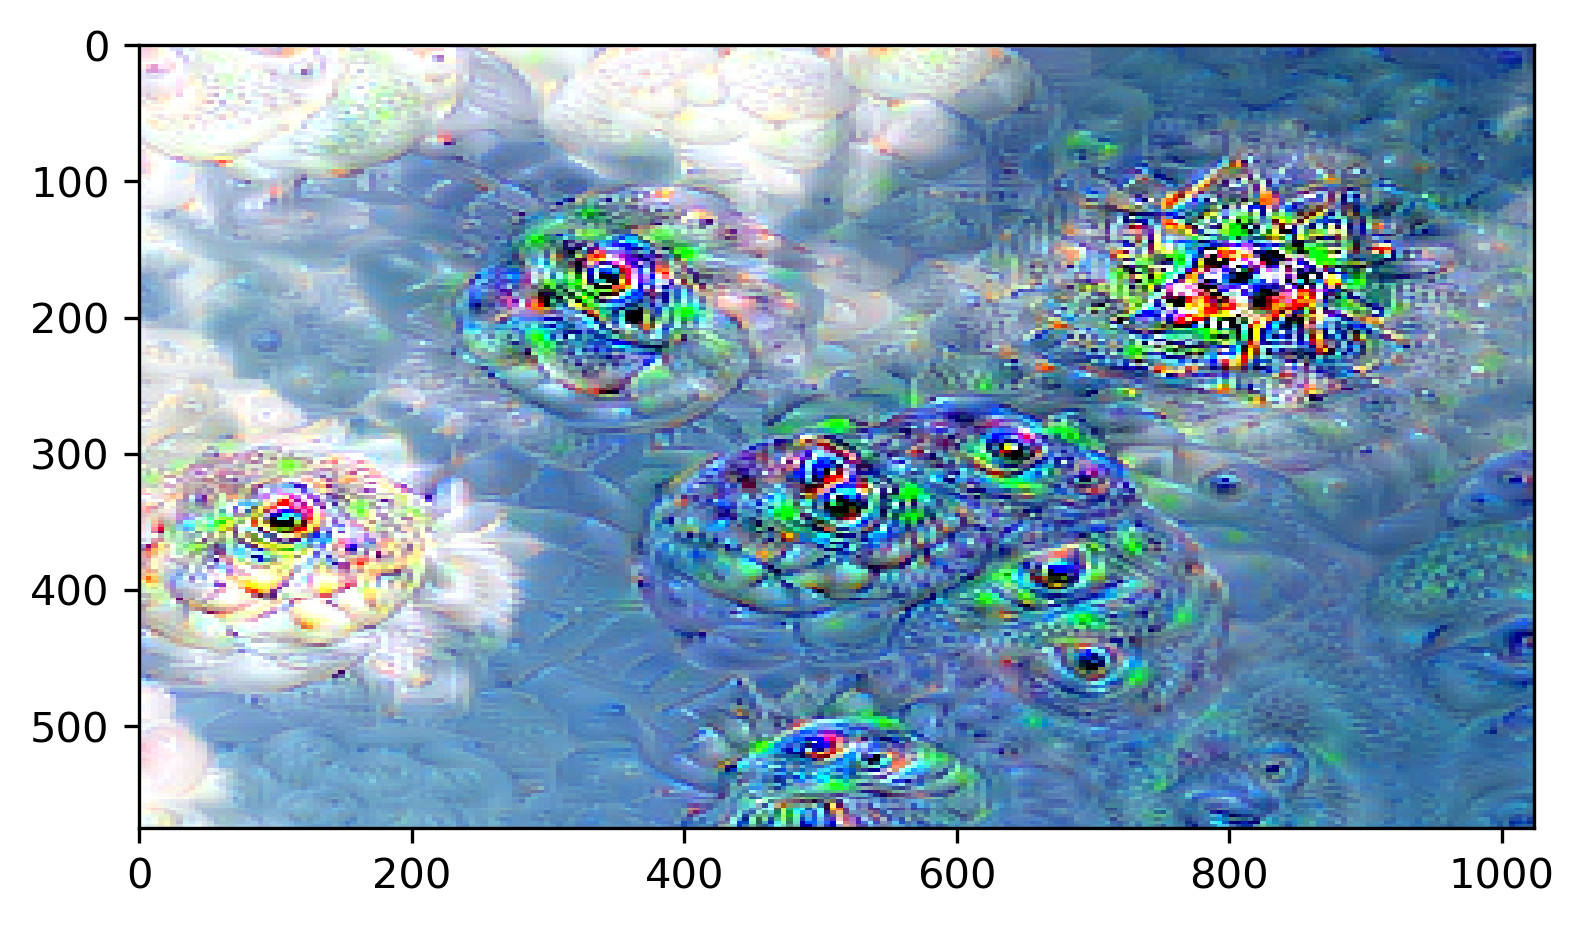

In [94]:
sky_28 = deep_dream_vgg(image=sky,modulelist=modulelist, layer=26, iterations=20, lr=0.2, octave_scale=2, num_octaves=20)

In [ ]:
lr, octave_scale, num_octaves

iterations 5
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
iterations 5
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
iterations 5
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
iterations 5
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
iterations 5
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
iterations 5
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
iterations 5
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
iterations 5
tensor(0., de

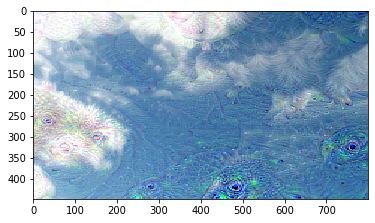

In [77]:
sky_28 = deep_dream_vgg(sky,modulelist, 28, 5, 0.2, 2, 20)